# Zhang 2023 Upper Bound Temperature
This looks at applying the theory from Byrne 2023 but to an aquaplanet.

Looks at how the hottest days compare to the theoretical upper bound temperature for a given the 500hPa temperature.

In [2]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, frierson_atmospheric_heating
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, radius_earth
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy.stats import percentileofscore

In [3]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
# only keep variables required to compute relative humidity, MSE and miyawaki R1 value
var_keep = ['temp', 'sphum', 'vcomp', 'ucomp', 'height']
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one dataset, `ds_lat`, for each latitude bin containing surface and free troposphere data for that latitude range.

In [91]:
# Get data set averaged over all summer days considering in each latitude bin.
# Do this for each optical depth value
use_time_start = 360*2
pressure_ft = 500

ds_use = ds[0].sel(time=slice(use_time_start, np.inf), drop=True)
ds_use = ds_use.sel(pfull=[pressure_ft, np.inf], method='nearest', drop=True).load()
z_ft_mean = float(ds_use.height[:, 0].mean())
temp_ft_mean = float(ds_use.temp[:, 0].mean())
pressure_ft_actual = float(ds_use.pfull[0])        # actual free troposphere pressure in hPa
pressure_surface = float(ds_use.pfull[1])          # surface pressure in hPa

In [47]:
temp_bins = np.linspace(ds_use.temp[:, 0].min(), ds_use.temp[:, 0].max(), 20)
z_bins = np.linspace(ds_use.height[:, 0].min(), ds_use.height[:, 0].max(), 20)
hist = np.histogram2d(ds_use.temp[:, 0].to_numpy().flatten(), ds_use.height[:, 0].to_numpy().flatten(), bins=[temp_bins, z_bins])[0]

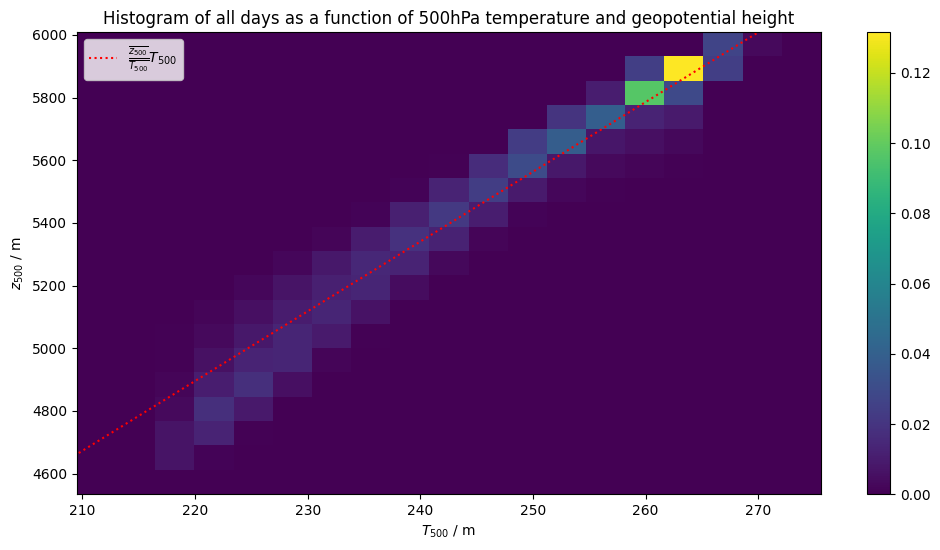

In [48]:
# Check that z_ft vs temp_ft relationship is approximately valid
temp_ft_array = np.arange(200, 300)
fig, ax = plt.subplots(1,1, figsize=(12, 6))
im = plt.imshow(hist.T/hist.sum(), origin='lower', aspect='auto', extent=[temp_bins[0], temp_bins[-1], z_bins[0], z_bins[-1]])
fig.colorbar(im)
ax.plot(temp_ft_array, (z_ft_mean/temp_ft_mean * temp_ft_array), color='r', linestyle=':',
        label='$\\frac{\overline{z_{500}}}{\overline{T_{500}}} T_{500}$')
ax.set_ylabel(f"$z_{'{'+str(pressure_ft)+'}'}$ / m")
ax.set_xlabel(f"$T_{'{'+str(pressure_ft)+'}'}$ / K")
ax.set_title(f'Histogram of all days as a function of {pressure_ft}hPa temperature and geopotential height')
ax.legend()
ax.set_xlim(temp_bins[0], temp_bins[-1])
ax.set_ylim(z_bins[0], z_bins[-1]);

In [49]:
# Compute free troposphere vorticity at each time, lon and lat
cos_lat = np.cos(np.deg2rad(ds_use.lat)).to_numpy().reshape(1, -1, 1)
np.gradient(ds_use.vcomp[:, 0], np.deg2rad(ds_use.lon), axis=2)
np.gradient(ds_use.ucomp[:, 0] * cos_lat, np.deg2rad(ds_use.lat), axis=1)
vorticity = (np.gradient(ds_use.vcomp[:, 0], np.deg2rad(ds_use.lon), axis=2) -
             np.gradient(ds_use.ucomp[:, 0] * cos_lat, np.deg2rad(ds_use.lat), axis=1)) / (radius_earth * cos_lat)
vorticity = xr.DataArray(vorticity, coords=ds_use.temp[:,0].coords)

In [66]:
# Compute theoretical upper bound on temperature if completely dry surface
def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1 + w_sat)
    return q_sat

temp_upper_bound = temp_ft_array + L_v/c_p * sphum_sat(temp_ft_array, pressure_ft_actual * 100) + \
                   g/c_p * z_ft_mean/temp_ft_mean * temp_ft_array

In [110]:
quant_plot = 90                 # show top 10 percentile temp in plots
lat_min = [0, 40, 70]
lat_max = [20, 65, 90]
n_lat = len(lat_min)
ds_lat = []
vorticity_lat = []
quant_thresh = np.zeros(n_lat)
with tqdm(total=n_lat, position=0, leave=True) as pbar:
    for i in range(n_lat):
        ds_use2 = ds_use.where((np.abs(ds_use.lat)<=lat_max[i]) & (np.abs(ds_use.lat)>=lat_min[i]), drop=True)
        ds_use2 = ds_use2[['temp', 'sphum', 'height']]      # Only keep min required variables
        vorticity2 = vorticity.where((np.abs(ds_use.lat)<=lat_max[i]) & (np.abs(ds_use.lat)>=lat_min[i]), drop=True)

        quant_thresh[i] = ds_use2.temp[:, -1].quantile(quant_plot/100, dim=['time', 'lat', 'lon'])
        keep = ds_use2.temp[:, -1] > quant_thresh[i]
        vorticity2 = vorticity2.where(keep, drop=True)
        # vorticity2 = vorticity2.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        vorticity_lat += [vorticity2]

        keep = np.expand_dims(keep, 1).repeat(ds_use2.temp.shape[1], axis=1)        # repeat keep for both pressure levels
        keep = xr.DataArray(keep, coords=ds_use2.coords)                           # Make it a data array
        ds_use2 = ds_use2.where(keep, drop=True)
        # Collapse lat, lon and time axis and get rid of any nan values corresponding to surface temp below quant_plot percentile
        # ds_use2 = ds_use2.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        # ds_use2 = ds_use2.sel(lon_lat_time = ds_use2.lon_lat_time[np.invert(np.isnan(ds_use2.temp[-1]))].to_numpy())
        ds_lat += [ds_use2]
        pbar.update(1)

100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


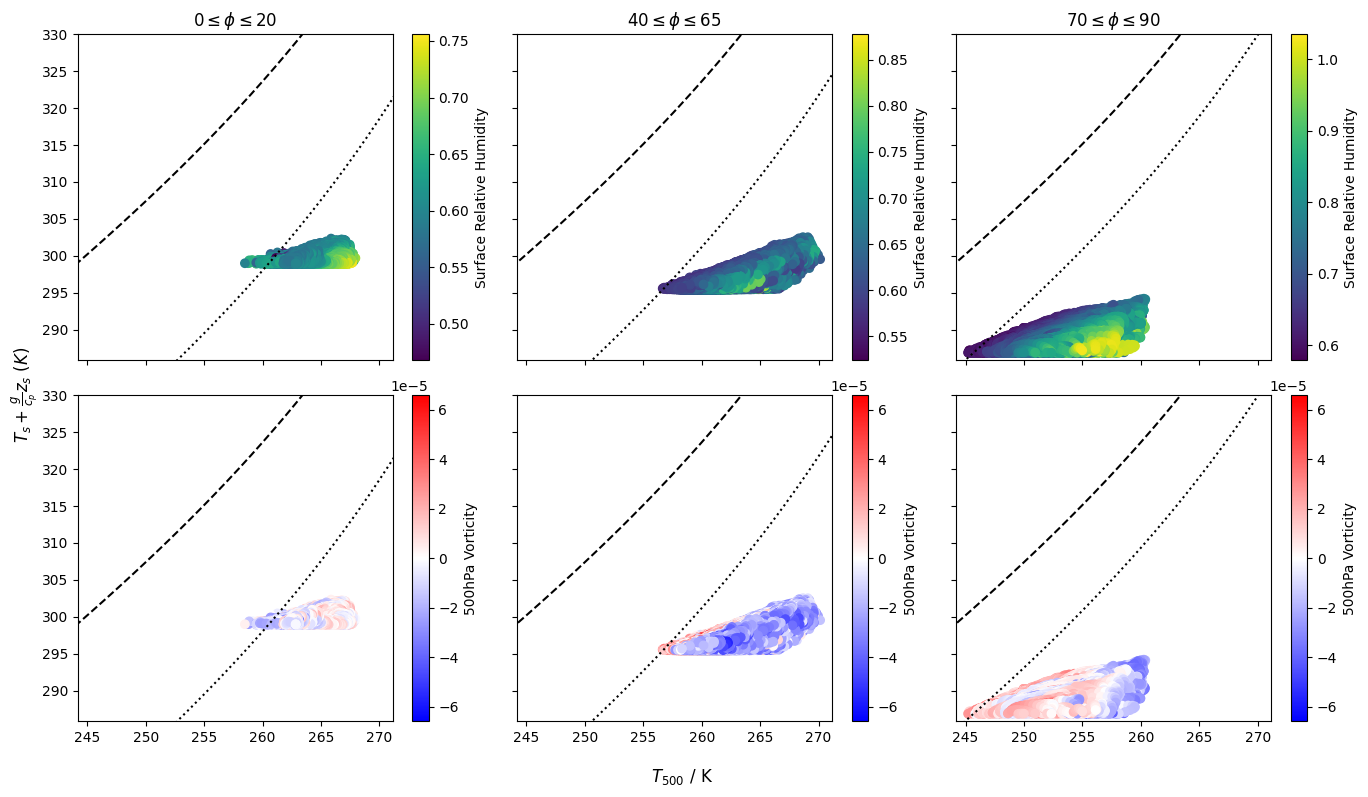

In [148]:
# This cell takes a long time to run!!
vorticity_max = 0.8 * np.max([np.abs(vorticity_lat[i]).max() for i in range(n_lat)])        # so vorticity on same scale on all plots
fig, ax = plt.subplots(2,3, figsize=(14,8), sharex=True, sharey=True)
for i in range(n_lat):
    im = ax[0, i].scatter(ds_lat[i].temp[:, 0], ds_lat[i].temp[:, -1],
                          c=ds_lat[i].sphum[:, -1]/sphum_sat(ds_lat[i].temp[:, -1], pressure_surface * 100))
    plt.colorbar(im, ax=ax[0, i], label='Surface Relative Humidity')
    im = ax[1, i].scatter(ds_lat[i].temp[:, 0], ds_lat[i].temp[:, -1],
                          c=vorticity_lat[i] * np.sign(vorticity_lat[i].lat), cmap='bwr', vmin=-vorticity_max, vmax=vorticity_max)
    plt.colorbar(im, ax=ax[1, i], label=f'{pressure_ft}hPa Vorticity')
    ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
    for k in range(2):
        # Plot upper bound and upper bound taking account of min surface sphum
        ax[k, i].plot(temp_ft_array, temp_upper_bound, color='k', linestyle='--')
        ax[k, i].plot(temp_ft_array, temp_upper_bound - float(L_v/c_p * ds_lat[i].sphum[:, -1].min()), color='k', linestyle=':')
fig.supxlabel(f"$T_{'{'+str(pressure_ft)+'}'}$ / K")
fig.supylabel('$T_s + \\frac{g}{c_p}z_s$ ($K$)')
ax[0, 0].set_xlim(np.min([ds_lat[i].temp[:, 0].min() for i in range(n_lat)])-1,
                  np.max([ds_lat[i].temp[:, 0].max() for i in range(n_lat)])+1)
ax[0, 0].set_ylim(quant_thresh.min()-1, 330)
plt.tight_layout()

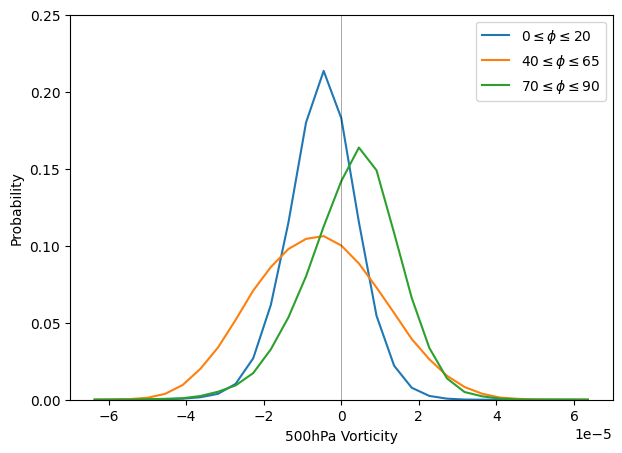

In [147]:
vorticity_bins = np.linspace(-vorticity_max,vorticity_max,30)
fig, ax = plt.subplots(1,1, figsize=(7,5), sharex=True)
for i in range(n_lat):
    hist = np.histogram((vorticity_lat[i]* np.sign(vorticity_lat[i].lat)).to_numpy().flatten(),
                        bins=vorticity_bins)
    ax.plot(np.convolve(vorticity_bins, np.ones(2)/2, mode='valid'), hist[0]/np.sum(hist[0]),
            label=f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
ax.vlines(0, 0.25, 0, color='k', alpha=0.6, linewidth=0.4)
ax.set_ylim(0, 0.25)
ax.legend()
ax.set_xlabel(f'{pressure_ft}hPa Vorticity')
ax.set_ylabel('Probability');

In all three regions, the gap between the scatter plot and the dotted line increases as $T_{500}$ does. This is because at each $T_{500}$ value, the minimum surface relative humidity is about the same but because the temperature increases, the saturation specific humidity increases and thus the surface specific humidity also does. So as $T_{500}$ increases, $q - q_{s, min}$ increases.

### High Latitudes, $70 \leq \phi \leq 90$
From the first plot, it seems that there is a strong trend for the 500hPa temperature to increase with surface relative humidity. This is in contrast to what we expect from Zhang 2023. But for a fixed 500hPa temperature, we see a trend for surface temperature to increase as surface relative humidity decreases, which is what we expect.

The second plot shows that there is a trend for the 500hPa temperature to increase as vorticity decreases i.e. becomes more anticyclonic. This matches what we expect from Zhang 2023.

This is the region that best matches the results in the paper, even though in the paper the mid latitude region is used. Maybe it is because this region includes the widest range of relative humidities.

### Midlatitudes, $40 \leq \phi \leq 65$
The second plot shows that the hottest days are associated with anticyclonic behaviour but the trend with $T_{500}$ is less obvious than at high latitudes.

For fixed $T_{500}$, there seems to be a slight trend for increasing surface temperature as relative humidity decreases, but again not as strong as at high latitudes.

### Tropics, $0 \leq \phi \leq 20$
The vorticity plot doesn't show any recognisable trend.
At the largest $T_{500}$, there seems to be a trend for surface temperature to increase as relative humidity decreases.